# LangGraph Tutorial


## Import Models


1. 导入相关的库、模块


In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

load_dotenv()

True

### 定义 LangGraph 状态图


In [2]:
class State(TypedDict):
  messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = init_chat_model('deepseek:deepseek-chat')

## Add tools


定义图形


In [3]:
from langchain_tavily import TavilySearch


tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
  return {'messages': [llm_with_tools.invoke(state['messages'])]}


graph_builder.add_node('chatbot', chatbot)


In [4]:
# 测试工具
tool.invoke('LangGraph 的 `node` 是什么？')

{'query': 'LangGraph 的 `node` 是什么？',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://zhuanlan.zhihu.com/p/720864252',
   'title': '初学LangGraph 之节点、边和状态 - 知乎专栏',
   'content': '节点（Nodes）： 是图的基本构建模块 。 每个节点代表一个特定的功能或操作，用来处理当前状态。 节点可以执行计算、修改状态，或者根据接收到的输入生成输出。 简单理解就是在节点内数据的流转是固定的。',
   'score': 0.8737439,
   'raw_content': None},
  {'url': 'https://zhuanlan.zhihu.com/p/681428515',
   'title': 'LangChain 发布的一个重要功能：LangGraph - 知乎专栏',
   'content': 'Node. 图中最关键的元素之一是节点。每个LangGraph节点都有一个名称和其值，它可以是LCEL中的函数或可运行项。每个节点接收一个字典类型的数据，其结构',
   'score': 0.8687491,
   'raw_content': None}],
 'response_time': 1.37}

创建自定义 Tool 函数


In [5]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
  """A node that runs the tools requested in the last AIMessage."""

  def __init__(self, tools: list) -> None:
    self.tools_by_name = {tool.name: tool for tool in tools}

  def __call__(self, inputs: dict):
    if messages := inputs.get('messages', []):
      message = messages[-1]
    else:
      raise ValueError('No message found in input')
    outputs = []
    for tool_call in message.tool_calls:
      print(f'Call tool function: {tool_call["name"]}, args: {tool_call["args"]}')
      tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])
      outputs.append(
        ToolMessage(
          content=json.dumps(tool_result),
          name=tool_call['name'],
          tool_call_id=tool_call['id'],
        )
      )
    return {'messages': outputs}


# 定义工具函数节点
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node('tools', tool_node)


# 路由函数实现
def route_tools(state: State):
  """
  Use in the conditional_edge to route to the ToolNode if the last message
  has tool calls. Otherwise, route to the end.
  """
  if isinstance(state, list):
    ai_message = state[-1]
  elif messages := state.get('messages', []):
    ai_message = messages[-1]
  else:
    raise ValueError(f'No messages found in input state to tool_edge: {state}')
  if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
    return 'tools'
  return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
  'chatbot',
  route_tools,
  # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
  # It defaults to the identity function, but if you
  # want to use a node named something else apart from "tools",
  # You can update the value of the dictionary to something else
  # e.g., "tools": "my_tools"
  {
    'tools': 'tools',
    END: END,
  },
)


使用预定义的工具函数


In [6]:
# from langgraph.prebuilt import ToolNode, tools_condition

# tool_node = ToolNode(tools=[tool])
# graph_builder.add_node('tools', tool_node)

# graph_builder.add_conditional_edges(
#   'chatbot',
#   tools_condition,
# )

## Add memory


In [7]:
from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

构建并编译图


In [8]:
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge(START, 'chatbot')
graph = graph_builder.compile(checkpointer=memory)


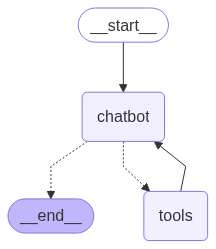

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### 选择一个主题（thread id）作为本次对话的关键词。


In [11]:
config = {'configurable': {'thread_id': '1'}}

In [12]:
# def stream_graph_updates(user_input: str):
#   for event in graph.stream(
#     {'messages': [{'role': 'user', 'content': user_input}]},
#     config,
#     stream_mode='values',
#   ):
#     for value in event.values():
#       print('Assistant:', value['messages'][-1].content)


# while True:
#   try:
#     user_input = input('User: ')
#     if user_input.lower() in ['quit', 'exit', 'q']:
#       print('Goodbye!')
#       break

#     stream_graph_updates(user_input)
#   except Exception:
#     # fallback if input() is not available
#     user_input = 'What do you know about LangGraph?'
#     print('User: ' + user_input)
#     stream_graph_updates(user_input)
#     break

### 使用 thread id: 1


In [13]:
user_input = '你好！我的名字叫 杨景'

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
  {'messages': [{'role': 'user', 'content': user_input}]},
  config,
  stream_mode='values',
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

你好！我的名字叫 杨景
================================== Ai Message ==================================

你好，杨景！很高兴认识你！有什么我可以帮你的吗？ 😊


In [14]:
user_input = '还记得我的名字吗？'

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
  {'messages': [{'role': 'user', 'content': user_input}]},
  config,
  stream_mode='values',
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

还记得我的名字吗？
================================== Ai Message ==================================

当然记得！你的名字是 **杨景**。有什么需要我帮忙的吗？ 😊


### 使用 thread id: 2


In [ ]:
# 使用不同的 thread_id 进行对话
events = graph.stream(
  {'messages': [{'role': 'user', 'content': user_input}]},
  {'configurable': {'thread_id': '2'}},  # change the `thread_id` here to '2' instead of '1'
  stream_mode='values',
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

还记得我的名字吗？
================================== Ai Message ==================================

目前我无法记住您的名字或任何个人信息。如果您愿意，可以告诉我您的名字，我会在本次对话中称呼您！


### 检查 state


In [20]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='你好！我的名字叫 杨景', additional_kwargs={}, response_metadata={}, id='5cf6e0b3-779a-4f44-80f2-7255cff7953a'), AIMessage(content='你好，杨景！很高兴认识你！有什么我可以帮你的吗？ 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1950, 'total_tokens': 1967, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1920}, 'prompt_cache_hit_tokens': 1920, 'prompt_cache_miss_tokens': 30}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '6419fe13-a808-4eb9-be6a-d95412ba7929', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--8eb61954-c77b-469c-bbc1-fdd0044544b2-0', usage_metadata={'input_tokens': 1950, 'output_tokens': 17, 'total_tokens': 1967, 'input_token_details': {'cache_read': 1920}, 'output_token_details': {}}), HumanMessage(content='还记得我的名字吗？', additional_kwargs={}, response_meta